# Space debris optimization

In this work, we solve the combinatorial optimization problem of space debris collection. A challenge for space agencies, satellite producers and any actor involved in space travel is to avoid space debris. In spite of possibly small sizes, their speeds on orbits make any collision with satellite or spacecraft threaten the success of space expeditions with major damage. Therefore, a major concern is to collect these debris and destroy them at the entrance of the atmosphere.

The problem is the following. Debris collection journeys are expensive, since the quantity of fuels used to propel the engins is massive, and the capacity of each space craft limits the amount of space garbage that can be collected. To optimize each trip to space, we must therefore seek debris located at particular locations, such that they minimize the distance and hence the fuel consumption, and they maximize the quantity of trash collected. We solve the latter problem first, and add further constraints to the problem progressively.

Let us first consider the problem of maximization of the volume of trash that is collected. This task is related to the knapsack problem. 

We start with a set of N debris. We encode the information about the debris to collect in a bitstring:
\begin{equation}
z = z_1 z_2 \cdots z_N, \text{where } z_i = \begin{cases}
1, & \text{if debris i is collected} \\
0, & \text{if otherwise.}
\end{cases}
\end{equation}

To solve the problem with brute force method, we must inspect all possible bitstrings $z$ and pick the one that maximizes the volume of the debris collected. Therefore, it is a combinatorial optimization problem. To formulate it, we pair each debris $i$ with its weight/size $w_i$. The debris locations can be reported on a graph with edge set $E$ and vertex set $V$ such that $G = \{E,V\}$. Each vertex is associated with a weight, and each edge $i -j$ with a distance $d_{ij}$. With these notations, we encode the problem into the cost function:
\begin{equation}
C(z) = (V-\sum_{i=1}^{N} w_i z_i)^2 + \sum_{i<j}^{N} d_{ij} z_i z_j
\end{equation}
where the first term corresponds to the knapsack problem and the second aims at minimizing the travelled distance. To simplify the implementation, the constant term can be removed:
\begin{align}
C(z) &=  \sum_{i=1}^{N} w_i^2 z_i^2 + 2\sum_{i<j}^N w_i w_j z_i z_j -  2V\sum_{i=1}^{N} w_i z_i + V^2 + \sum_{i<j}^{N} d_{ij} z_i z_j \\
 & = \sum_{i=1}^{N} w_i^2 z_i + 2\sum_{i<j}^N w_i w_j z_i z_j -  2V\sum_{i=1}^{N} w_i z_i + \sum_{i<j}^{N} d_{ij} z_i z_j
\end{align}

In [1]:
import sys
!{sys.executable} -m pip install pennylane
!{sys.executable} -m pip install networkx
!pip install dwave-ocean-sdk
!pip install dwave-qbsolv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.8 MB/s 
     |████████████████████████████████| 1.6 MB 61.2 MB/s 
     |████████████████████████████████| 13.6 MB 30.1 MB/s 
     |████████████████████████████████| 108 kB 99.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 6.2 MB/s 
     |████████████████████████████████| 658 kB 50.7 MB/s 
     |████████████████████████████████| 5.3 MB 32.7 MB/s 
     |████████████████████████████████| 108 kB 103.9 MB/s 
     |████████████████████████████████| 700 kB 72.9 MB/s 
     |████████████████████████████████| 966 kB 66.8 MB/s 
     |████████████████████████████████| 97 kB 9.7 MB/s 
     |████████████████████████████████| 497 kB 58.9 MB/s 
     |████

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import numpy as np
from collections import defaultdict

We start with a dummy data set with 5 debris.

{('0', '1'): Text(-0.31213490044069825, 0.0229285235823255, '1'),
 ('0', '2'): Text(0.18180059090333675, -0.7976561108038269, '2'),
 ('0', '3'): Text(-0.6981592185316541, -0.4262551763130149, '2'),
 ('0', '4'): Text(0.2340158724740534, -0.207744883060842, '1'),
 ('1', '2'): Text(0.26598412752594675, 0.16442417717540436, '1'),
 ('1', '3'): Text(-0.6139756819090442, 0.5358251116662163, '2'),
 ('1', '4'): Text(0.3181994090966634, 0.7543354049183892, '2'),
 ('2', '3'): Text(-0.12004019056500914, -0.28475952271993604, '1'),
 ('2', '4'): Text(0.8121349004406984, -0.06624922946776313, '2'),
 ('3', '4'): Text(-0.0678249089942925, 0.30515170502304884, '1')}

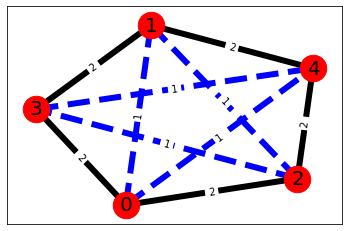

In [3]:
N_vertices = 5
G = nx.Graph()

for i in range(0,N_vertices):
  for j in range(i+1,N_vertices):
    if (j-i)%3 == 1:
      G.add_edge(str(i), str(j), weight=1)
    else:
      G.add_edge(str(i), str(j), weight=2)

heavy_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 1]
light_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 1]
pos = nx.spring_layout(G, seed=11) 
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="r")
nx.draw_networkx_edges(G, pos, edgelist=heavy_edges, width=6)
nx.draw_networkx_edges(G, pos, edgelist=light_edges, width=6, edge_color="b", style="dashed")
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

In [4]:
w = [1,2,7,4,5]
Q = defaultdict(int)

In [5]:
# Constraint Knapsack enncoded
for i in range(len(w)):
  for j in range(i+1,len(w)):
    # print(i,j)
    # print()
    # print(2*w[i]*w[j])
    Q[(i,j)] = 2*w[i]*w[j]

In [6]:
for i in range(len(w)):
  # print(i,i)
  Q[(i,i)] = w[i]**2

In [7]:
for i in range(len(w)):
  # print(i,i)
  Q[(i,i)] += -20*w[i]

In [8]:
distances = nx.get_edge_attributes(G, "weight")

In [14]:
#Objective TSP encoded
for i in range(len(w)):
  for j in range(i+1,len(w)):
    Q[(i,j)] += distances[(str(i),str(j))]

In [15]:
Q

defaultdict(int,
            {(0, 1): 5,
             (0, 2): 16,
             (0, 3): 10,
             (0, 4): 11,
             (1, 2): 29,
             (1, 3): 18,
             (1, 4): 22,
             (2, 3): 57,
             (2, 4): 72,
             (3, 4): 41,
             (0, 0): -19,
             (1, 1): -36,
             (2, 2): -91,
             (3, 3): -64,
             (4, 4): -75})

In [16]:
from dimod import BinaryQuadraticModel
from dwave_qbsolv import QBSolv
BQM = BinaryQuadraticModel.from_qubo(Q)
response = QBSolv().sample(BQM)
response

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: QBSolv is deprecated as of the end of 2021 and support will be discontinued after March 2022. Please update your code to use dwave-hybrid or Leap's quantum-classical hybrid solvers instead.
  after removing the cwd from sys.path.


SampleSet(rec.array([([0, 0, 1, 1, 0], -98., 16), ([0, 1, 1, 0, 0], -98., 12),
           ([0, 0, 0, 1, 1], -98., 23)],
          dtype=[('sample', 'i1', (5,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables([0, 1, 2, 3, 4]), {}, 'BINARY')

In [12]:
w

[1, 2, 7, 4, 5]

In [17]:
sampler = DWaveSampler(token = 'DEV-a93e6e63ce7eef68a4af19e93761099699f4cbe5')
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, num_reads = 100)
response

SampleSet(rec.array([([0, 0, 0, 1, 1], -98., 11, 0.),
           ([0, 0, 1, 1, 0], -98., 16, 0.),
           ([0, 1, 1, 0, 0], -98., 12, 0.),
           ([1, 1, 1, 0, 0], -96.,  8, 0.),
           ([1, 0, 0, 1, 1], -96.,  9, 0.),
           ([0, 1, 0, 1, 1], -94., 11, 0.),
           ([1, 0, 1, 0, 0], -94.,  5, 0.),
           ([1, 1, 0, 0, 1], -92.,  9, 0.),
           ([1, 0, 1, 1, 0], -91.,  4, 0.),
           ([0, 0, 1, 0, 0], -91.,  3, 0.),
           ([0, 1, 0, 0, 1], -89.,  3, 0.),
           ([1, 1, 0, 1, 1], -87.,  3, 0.),
           ([0, 1, 1, 1, 0], -87.,  3, 0.),
           ([1, 1, 0, 1, 0], -86.,  1, 0.),
           ([1, 0, 0, 0, 1], -83.,  1, 0.),
           ([0, 1, 1, 0, 1], -79.,  1, 0.)],
          dtype=[('sample', 'i1', (5,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), Variables([0, 1, 2, 3, 4]), {'timing': {'qpu_sampling_time': 12028.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 79.74, 'qpu_access_time':